In [1]:
import torch
import torch.nn as nn
import numpy as np
from sklearn import preprocessing
import math
import numpy as np
from numpy import linalg as LA

In [ ]:
%%time

# download the data here: https://doi.org/10.7910/DVN/6C3JR1

direc = "../input/tennessee-eastman-process-simulation-dataset/"
#direc = './'

train_normal_path = direc+'TEP_FaultFree_Training.RData'
train_faulty_path = direc+'TEP_Faulty_Training.RData'

test_normal_path = direc+'TEP_FaultFree_Testing.RData'
test_faulty_path = direc+'TEP_Faulty_Testing.RData'

train_normal_complete = pyreadr.read_r(train_normal_path)['fault_free_training']
#train_faulty_complete = pyreadr.read_r(train_fault_path)['faulty_training']

#test_normal_complete = pyreadr.read_r(test_normal_path)['fault_free_testing']
test_faulty_complete = pyreadr.read_r(test_faulty_path)['faulty_testing']

cols = train_normal_complete.columns[3:]

In [4]:
torch.cuda.current_device(),torch.cuda.is_available()

(0, True)

In [86]:
data = np.fromfile('./data/d00.dat', dtype=np.float32, sep='   ')
data.shape

(49920,)

In [80]:
49920/52

960.0

In [81]:
def read_data(error=0, unit=[0], is_train=True):
    """
    Args:p
        error (int): The index of error, 0 means normal data
        is_train (bool): Read train or test data
    Returns:
        units' data
    """

    if is_train:
        suffix = '.dat'
    else:
        suffix = '_te.dat'
    fi = './data/d{:02d}{}'.format(error, suffix)
    data = np.fromfile(fi, dtype=np.float32, sep='   ')

    if fi == './data/d00.dat':
        # data = data.reshape(-1, 500).T
        data = data.reshape(-1, 52)
        data = data[:, unit]  #获取特定列的元素
    else:
        data = data.reshape(-1, 52)
        data = data[:, unit]
    # if not is_train:
    #     data = data[160: ]
    return data, np.ones(data.shape[0], np.float32) * error  #获取数据以及标签

In [32]:
def get_train_data(unit):
    train_data, _ = read_data(error=0, unit=unit, is_train=True)
    train_data = preprocessing.StandardScaler().fit_transform(train_data)
    return train_data  #训练数据归一化

In [33]:
def get_test_data(unit):
    test_data = []
    for i in range(22):
        data, _ = read_data(error=i, unit=unit, is_train=False)
        test_data.append(data)
    test_data = np.concatenate(test_data) #拉成长度为[22*960,unit_size]
    train_data, _ = read_data(error=0, unit=unit, is_train=True)
    scaler = preprocessing.StandardScaler().fit(train_data)
    return test_data  

In [34]:
test = get_test_data([0,1,2,3])
test.shape

(960, 4)

## global-local-transformer-model

In [35]:
class EmbedddingModel(nn.Module):
    def __init__(self, unit_len=[]):
        super(EmbedddingModel, self).__init__()
        self.unit_len1 = unit_len[0]
        self.unit_len2 = unit_len[1]
        self.unit_len3 = unit_len[2]
        self.unit_len4 = unit_len[3]
        self.unit_len5 = unit_len[4]

        self.embed1 = nn.Sequential(
            nn.Linear(self.unit_len1, 64, bias=True),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 16, bias=True)
        )
        self.nonlinear1 = nn.Sequential(
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Linear(16, 64, bias=True)
        )

        self.embed2 = nn.Sequential(
            nn.Linear(self.unit_len2, 64, bias=True),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 16, bias=True)
        )
        self.nonlinear2 = nn.Sequential(
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Linear(16, 64, bias=True)
        )

        self.embed3 = nn.Sequential(
            nn.Linear(self.unit_len3, 64, bias=True),
            nn.ReLU(),
            nn.BatchNorm1d(64),
             
            nn.Linear(64, 16, bias=True)
        )
        self.nonlinear3 = nn.Sequential(
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Linear(16, 64, bias=True)
        )

        self.embed4 = nn.Sequential(
            nn.Linear(self.unit_len4, 64, bias=True),
            nn.ReLU(),
            nn.BatchNorm1d(64),
              
            nn.Linear(64, 16, bias=True)
        )
        self.nonlinear4 = nn.Sequential(
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Linear(16, 64, bias=True)
        )

        self.embed5 = nn.Sequential(
            nn.Linear(self.unit_len5, 64, bias=True),
            nn.ReLU(),
            nn.BatchNorm1d(64),
              
            nn.Linear(64, 16, bias=True)
        )
        self.nonlinear5 = nn.Sequential(
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Linear(16, 64, bias=True)
        )
        
    def forward(self, x1, x2, x3, x4, x5):
        h1 = self.embed1(x1)
        y1 = self.nonlinear1(h1)
        h2 = self.embed2(x2)
        y2 = self.nonlinear2(h2)
        h3 = self.embed3(x3)
        y3 = self.nonlinear3(h3)
        h4 = self.embed4(x4)
        y4 = self.nonlinear4(h4)
        h5 = self.embed5(x5)
        y5 = self.nonlinear5(h5)
        hidden_state = torch.cat((h1, h2, h3, h4, h5), dim=1)  
        src = torch.stack((y1, y2, y3, y4, y5), dim=0)  
        return hidden_state, src

In [36]:
T1 = torch.tensor([[1, 2, 3],
        		[4, 5, 6],
        		[7, 8, 9]])
T2 = torch.tensor([[10, 20, 30],
        		[40, 50, 60],
        		[70, 80, 90]])

In [37]:
y = torch.stack((T1,T2),dim=1)

y

tensor([[[ 1,  2,  3],
         [10, 20, 30]],

        [[ 4,  5,  6],
         [40, 50, 60]],

        [[ 7,  8,  9],
         [70, 80, 90]]])

In [38]:
class TransformerModel(nn.Module):
    def __init__(self):
        super(TransformerModel, self).__init__()
        self.embed = EmbedddingModel([8, 7, 6, 7, 5])
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=64, nhead=8, dim_feedforward=1024, dropout=0.01,
                                                        activation="relu")
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=6)
        self.avg1 = nn.Linear(64, 4)
        self.linear1 = nn.Linear(4, 8, bias=True)
        self.linear2 = nn.Linear(4, 7, bias=True)
        self.linear3 = nn.Linear(4, 6, bias=True)
        self.linear4 = nn.Linear(4, 7, bias=True)
        self.linear5 = nn.Linear(4, 5, bias=True)


    def forward(self, x1, x2, x3, x4, x5):
        hidden_state, src = self.embed(x1, x2, x3, x4, x5)
        memory = self.encoder(src)  
        memory = self.avg1(memory.permute(1, 0, 2)) # torch.permute()进行维度换位
        memory = memory.permute(1, 0, 2)  
        hidden_fea1, hidden_fea2, hidden_fea3, hidden_fea4, hidden_fea5 = torch.chunk(memory, 8, dim=0) #(1,500,4)
        hidden_fea1 = torch.squeeze(hidden_fea1)  
        hidden_fea2 = torch.squeeze(hidden_fea2)
        hidden_fea3 = torch.squeeze(hidden_fea3)
        hidden_fea4 = torch.squeeze(hidden_fea4)
        hidden_fea5 = torch.squeeze(hidden_fea5)
        out = torch.cat((hidden_fea1, hidden_fea2, hidden_fea3, hidden_fea4, hidden_fea5),dim=1) #全局特征(500,20)
        fea1 = self.linear1(hidden_fea1) 
        fea2 = self.linear2(hidden_fea2)
        fea3 = self.linear3(hidden_fea3)
        fea4 = self.linear4(hidden_fea4)
        fea5 = self.linear5(hidden_fea5)
        decoder_out = torch.cat((fea1, fea2, fea3, fea4, fea5), dim=1) 
        return decoder_out, out, hidden_state

In [39]:
position = torch.randn(2,4,3)
position = position.permute(1,0,2)
position.shape

torch.Size([4, 2, 3])

In [40]:
class PositionalEncoding(nn.Module):
    #Implement the PE function

    def __init__(self, max_len, d_model ):
        super(PositionalEncoding, self).__init__()

        # Compute the positional encodings once in log space.
        if d_model%2 ==0:
            pe = torch.zeros(max_len, d_model)
            position = torch.arange(0, max_len).unsqueeze(1) #在维度1上增加一个维度,变成2维
            div_term = torch.exp(torch.arange(0, d_model, 2) *
                                -(math.log(10000.0) / d_model))
            pe[:, 0::2] = torch.sin(position * div_term)  #传统SCPE公式
            pe[:, 1::2] = torch.cos(position * div_term)
            pe = pe.unsqueeze(0)
        if d_model%2 ==1:
            pe = torch.zeros(max_len, d_model+1)
            position = torch.arange(0, max_len).unsqueeze(1)
            div_term = torch.exp(torch.arange(0, d_model, 2) *
                                -(math.log(10000.0) / d_model))
            pe[:, 0::2] = torch.sin(position * div_term)
            pe[:, 1::2] = torch.cos(position * div_term)
            pe = pe[:,:d_model]
            pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = torch.permute(x,(1,0,2)) 
        z = self.pe[:, :x.size(1)].clone().detach()
        x = x + z     #对x进行位置编码
        return x.permute(1,0,2)

In [41]:
? torch.chunk

Docstring:
chunk(input, chunks, dim=0) -> List of Tensors

Attempts to split a tensor into the specified number of chunks. Each chunk is a view of
the input tensor.


.. note::

    This function may return less then the specified number of chunks!

.. seealso::

    :func:`torch.tensor_split` a function that always returns exactly the specified number of chunks

If the tensor size along the given dimesion :attr:`dim` is divisible by :attr:`chunks`,
all returned chunks will be the same size.
If the tensor size along the given dimension :attr:`dim` is not divisible by :attr:`chunks`,
all returned chunks will be the same size, except the last one.
If such division is not possible, this function may return less
than the specified number of chunks.

Arguments:
    input (Tensor): the tensor to split
    chunks (int): number of chunks to return
    dim (int): dimension along which to split the tensor

Example::
    >>> torch.arange(11).chunk(6)
    (tensor([0, 1]),
     tensor([2, 3]),
    

In [42]:
class TransformerPe(nn.Module):
    def __init__(self):
        super(TransformerPe, self).__init__()
        self.embed = EmbedddingModel([8, 7, 6, 7, 5])
        self.PE = PositionalEncoding(5, 5)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=69, nhead=3, dim_feedforward=1024, dropout=0.01,
                                                        activation="relu")                                          #注意d_model和nhead的维度一致
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=6)
        self.avg1 = nn.Linear(69, 4)
        self.linear1 = nn.Linear(4, 8, bias=True)
        self.linear2 = nn.Linear(4, 7, bias=True)
        self.linear3 = nn.Linear(4, 6, bias=True)
        self.linear4 = nn.Linear(4, 7, bias=True)
        self.linear5 = nn.Linear(4, 5, bias=True)


    def forward(self, x1, x2, x3, x4, x5):
        hidden_state, src = self.embed(x1, x2, x3, x4, x5)
        src_pe = self.PE(src)
        memory = self.encoder(src_pe) #(5,500,128)
        memory = self.avg1(memory.permute(1, 0, 2))
        memory = memory.permute(1, 0, 2)
        hidden_fea1, hidden_fea2, hidden_fea3, hidden_fea4, hidden_fea5 = torch.chunk(memory, 8, dim=0)
        hidden_fea1 = torch.squeeze(hidden_fea1)
        hidden_fea2 = torch.squeeze(hidden_fea2)
        hidden_fea3 = torch.squeeze(hidden_fea3)
        hidden_fea4 = torch.squeeze(hidden_fea4)
        hidden_fea5 = torch.squeeze(hidden_fea5)
        out = torch.cat((hidden_fea1, hidden_fea2, hidden_fea3, hidden_fea4, hidden_fea5),dim=1) #全局特征
        fea1 = self.linear1(hidden_fea1)
        fea2 = self.linear2(hidden_fea2)
        fea3 = self.linear3(hidden_fea3)
        fea4 = self.linear4(hidden_fea4)
        fea5 = self.linear5(hidden_fea5)
        decoder_out = torch.cat((fea1, fea2, fea3, fea4, fea5), dim=1) #重构输出
        return decoder_out, out, hidden_state

In [43]:
class OPE(nn.Module):
    #Implement the OPE function

    def __init__(self, max_len, d_model ):
        super(OPE, self).__init__()

        c = np.zeros((d_model, d_model))
        for i in range(d_model):
            for j in range(d_model):
                c[i,j] = 0.9**np.abs(i-j)
        np.set_printoptions(precision=4)
        w, v = LA.eig(c)
        pe = np.zeros((max_len, d_model-1))
        for i in range(max_len):
            pe[i,:] = v[i,1:]    
        pe = torch.unsqueeze(torch.from_numpy(pe),0) 
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = torch.permute(x,(1,0,2)) 
        z = self.pe[:, :x.size(1)].clone().detach()
        x = x + z      
        return x.permute(1,0,2).to(torch.float32)  #(5,500,128)

In [44]:
class TransformerPE(nn.Module):
    def __init__(self):
        super(TransformerPE, self).__init__()
        self.embed = EmbedddingModel([8, 7, 6, 7, 5])
        self.PE = OPE(5, 65)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=64, nhead=8, dim_feedforward=1024, dropout=0.01,
                                                        activation="relu")                                          #注意d_model和nhead的维度一致
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=6)
        self.avg1 = nn.Linear(64, 4)
        self.linear1 = nn.Linear(4, 8, bias=True)
        self.linear2 = nn.Linear(4, 7, bias=True)
        self.linear3 = nn.Linear(4, 6, bias=True)
        self.linear4 = nn.Linear(4, 7, bias=True)
        self.linear5 = nn.Linear(4, 5, bias=True)


    def forward(self, x1, x2, x3, x4, x5):
        hidden_state, src = self.embed(x1, x2, x3, x4, x5)
        src_pe = self.PE(src)
        memory = self.encoder(src_pe) #(5,500,128)
        memory = self.avg1(memory.permute(1, 0, 2))
        memory = memory.permute(1, 0, 2)
        hidden_fea1, hidden_fea2, hidden_fea3, hidden_fea4, hidden_fea5 = torch.chunk(memory, 8, dim=0)
        hidden_fea1 = torch.squeeze(hidden_fea1)
        hidden_fea2 = torch.squeeze(hidden_fea2)
        hidden_fea3 = torch.squeeze(hidden_fea3)
        hidden_fea4 = torch.squeeze(hidden_fea4)
        hidden_fea5 = torch.squeeze(hidden_fea5)
        out = torch.cat((hidden_fea1, hidden_fea2, hidden_fea3, hidden_fea4, hidden_fea5),dim=1) 
        fea1 = self.linear1(hidden_fea1)
        fea2 = self.linear2(hidden_fea2)
        fea3 = self.linear3(hidden_fea3)
        fea4 = self.linear4(hidden_fea4)
        fea5 = self.linear5(hidden_fea5)
        decoder_out = torch.cat((fea1, fea2, fea3, fea4, fea5), dim=1) 
        return decoder_out, out, hidden_state

### 训练

In [45]:
import time
import os
import torch
import torch.nn as nn
from torch import optim
from torch.optim import lr_scheduler
# from model import TransformerPE
# from utils import get_train_data, get_test_data
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import random
import torch.nn.functional as F

In [71]:
def train():
    model = TransformerPE()
    model.to(device)
    Epoch = 1800
    optimizer = optim.Adam(model.parameters(), lr=0.002, betas=(0.9, 0.99), eps=1e-08, weight_decay=0.0001)  # alt+enter
    scheduler = lr_scheduler.MultiStepLR(optimizer, [500], 0.5)
    criterion = nn.MSELoss()
    model.train()
    epoches = []
    train_loss = []
    test_loss = []

    for epoch in range(Epoch):
        running_loss = 0.0
        optimizer.zero_grad()
        decoder_out, out, _ = model(train_data_unit1, train_data_unit2, train_data_unit3, train_data_unit4,train_data_unit5)
        loss = criterion(decoder_out, train_data)
        loss.backward()
        optimizer.step()
        scheduler.step()
        running_loss += loss.item()

        if (epoch + 1) % 50 == 0:
            print('epoch_{}'.format(epoch+1))
            print('training_loss:{}'.format(running_loss))
            epoches.append(epoch)
            train_loss.append(running_loss)
            #保存模型参数
            base_path = "./TE/model/"
            if not os.path.exists(base_path):
                os.makedirs(base_path)
            torch.save(model.state_dict(),os.path.join(base_path, "transformer_para_{}".format(epoch + 1)))
            # model.load_state_dict(
            #     torch.load(os.path.join(base_path, "transformer_para_{}".format(epoch + 1))))
            
            model.eval()
            running_loss_0 = 0.0
            with torch.no_grad():
                decoder_out, out, hidden_state = model(test_data_unit1, test_data_unit2, test_data_unit3, test_data_unit4, test_data_unit5)
                loss = criterion(decoder_out, test_data)
                running_loss_0 += loss.item()
                test_loss.append(running_loss_0)
                print('testing_loss:{}'.format(loss))
                
            global_fea = out.detach().cpu().numpy()
            local_fea = hidden_state.detach().cpu().numpy()
            #print(local_fea.shape),(21120,128)
            mat1 = {'fea_test': global_fea.T}
            mat2 = {'fea_test': local_fea.T}
            save_path = "./TE/feature/"
            if not os.path.exists(save_path):
                os.makedirs(save_path)
            sio.savemat(os.path.join(save_path,"fea_glo_{}.mat".format(epoch + 1)), mat1)
            sio.savemat(os.path.join(save_path,"fea_loc_{}.mat".format(epoch + 1)), mat2)
            # print("testing is finished!")


    print("time span: %.4f s" % (time.time() - start))
    # plt.plot(epoches, train_loss, color='r', label='train loss')
    plt.figure()
    plt.plot(epoches, test_loss, color='b', label='test loss')
    plt.figure()
    plt.plot(epoches, train_loss, color='r', label='train_loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc="best")
    plt.show()

In [72]:
def test():
    model = TransformerPE()
    model.to(device)

    base_path = "./TE/model/"
    model.load_state_dict(
        torch.load(os.path.join(base_path, "transformer_para_{}".format(1800))))
    # model.load_state_dict(torch.load("./TE/transformer_para_1800"))
    model.eval()

    with torch.no_grad():
        decoder_out, out, hidden_state = model(test_data_unit1, test_data_unit2, test_data_unit3, test_data_unit4, test_data_unit5)
        n = decoder_out - test_data
 
        
    global_fea = out.detach().cpu().numpy()
    local_fea = hidden_state.detach().cpu().numpy()
    res = n.detach().cpu().numpy()

    mat1 = {'fea_test': global_fea.T}
    mat2 = {'fea_test': local_fea.T}
    mat3 = {'res_test': res.T}


    save_path = "./TE/feature/222/"
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    sio.savemat(os.path.join(save_path,"fea_glo.mat"), mat1)
    sio.savemat(os.path.join(save_path,"fea_loc.mat"), mat2)
    sio.savemat(os.path.join(save_path,"res.mat"), mat3)
  
    print('finishing!')

In [82]:
if __name__ == '__main__':
    start = time.time()

    unit1 = [0, 1, 2, 3, 41, 42, 43, 44]
    unit2 = [5, 6, 7, 8, 20, 50, 51]
    unit3 = [10, 11, 12, 13, 21, 47]
    unit4 = [14, 15, 16, 17, 18, 48, 49]
    unit5 = [4, 9, 19, 45, 46]
    unit_list = [unit1, unit2, unit3, unit4, unit5]
    unit_variables = unit1+unit2+unit3+unit4+unit5
    unit_variables = [i+1 for i in unit_variables]
    unit_len = [8, 7, 6, 7, 5]

    train_data_unit1 = get_train_data(unit1)
    train_data_unit1 = torch.from_numpy(train_data_unit1)
    train_data_unit2 = get_train_data(unit2)
    train_data_unit2 = torch.from_numpy(train_data_unit2)
    train_data_unit3 = get_train_data(unit3)
    train_data_unit3 = torch.from_numpy(train_data_unit3)
    train_data_unit4 = get_train_data(unit4)
    train_data_unit4 = torch.from_numpy(train_data_unit4)
    train_data_unit5 = get_train_data(unit5)
    train_data_unit5 = torch.from_numpy(train_data_unit5)
    train_data = torch.cat((train_data_unit1, train_data_unit2, train_data_unit3, train_data_unit4, train_data_unit5),dim=1)

    test_data_unit1 = get_test_data(unit1)
    test_data_unit1 = torch.from_numpy(test_data_unit1)
    test_data_unit2 = get_test_data(unit2)
    test_data_unit2 = torch.from_numpy(test_data_unit2)
    test_data_unit3 = get_test_data(unit3)
    test_data_unit3 = torch.from_numpy(test_data_unit3)
    test_data_unit4 = get_test_data(unit4)
    test_data_unit4 = torch.from_numpy(test_data_unit4)
    test_data_unit5 = get_test_data(unit5)
    test_data_unit5 = torch.from_numpy(test_data_unit5)
    test_data = torch.cat((test_data_unit1, test_data_unit2, test_data_unit3, test_data_unit4, test_data_unit5),dim=1)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    train_data = train_data.to(device)
    train_data_unit1 = train_data_unit1.to(device)
    train_data_unit2 = train_data_unit2.to(device)
    train_data_unit3 = train_data_unit3.to(device)
    train_data_unit4 = train_data_unit4.to(device)
    train_data_unit5 = train_data_unit5.to(device)

    test_data = test_data.to(device)
    test_data_unit1 = test_data_unit1.to(device)
    test_data_unit2 = test_data_unit2.to(device)
    test_data_unit3 = test_data_unit3.to(device)
    test_data_unit4 = test_data_unit4.to(device)
    test_data_unit5 = test_data_unit5.to(device)

    

epoch_50
training_loss:0.6895923614501953
testing_loss:1102277.875
epoch_100
training_loss:0.41996943950653076
testing_loss:1101868.375
epoch_150
training_loss:0.24827080965042114
testing_loss:1101889.5
epoch_200
training_loss:0.18639397621154785
testing_loss:1101895.75
epoch_250
training_loss:0.15197598934173584
testing_loss:1101927.375
epoch_300
training_loss:0.14125092327594757
testing_loss:1101855.25
epoch_350
training_loss:0.13424722850322723
testing_loss:1101807.125
epoch_400
training_loss:0.1345810443162918
testing_loss:1101789.25
epoch_450
training_loss:0.13104723393917084
testing_loss:1101764.875
epoch_500
training_loss:0.1313045471906662
testing_loss:1101754.0
epoch_550
training_loss:0.12981343269348145
testing_loss:1101797.875
epoch_600
training_loss:0.12960907816886902
testing_loss:1101832.375
epoch_650
training_loss:0.1294720321893692
testing_loss:1101843.375
epoch_700
training_loss:0.13005316257476807
testing_loss:1101857.0
epoch_750
training_loss:0.12933850288391113
test

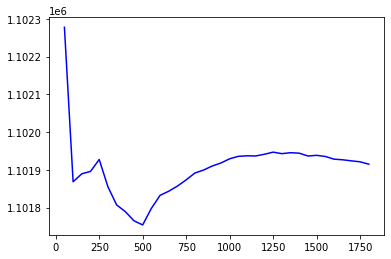

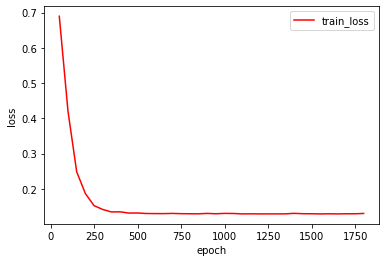

In [84]:
train()
test()

In [85]:
test_data.shape

torch.Size([500, 33])

In [22]:
21120/22

960.0

In [2]:
torch.cuda.current_device()

0